# Theory and Practice of Deep Learning
## Coding Homework 1: Discriminative Machine Learning
## Keshigeyan Chandrasegaran - 1002327

In this coding homework, we will run a simple ML project. The goal of this coding homework is to recap recap on how to run a simple machine learning project. The required resources are 
1. Extracted 17flowers.tgz (which will be ./jpg/) 
2. flowers17feats.zip (The notebook will automatically extract this zip file to the parent directory)

### Helper Functions

In [1]:
# importing required modules 
from zipfile import ZipFile
from tqdm import tqdm
import numpy as np
import os
from sklearn.model_selection import train_test_split
import pandas as pd
import re
import math
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from random import shuffle
import cv2
import statistics as s

# opening the zip file in READ mode 
def extractFiles(file_name, verbose = 0):
    with ZipFile(file_name, 'r') as zip: 
        # printing all the contents of the zip file
        if verbose == 1:
            zip.printdir() 

        # extracting all the files 
        print('Extracting all the files now from {}'.format(file_name)) 
        zip.extractall()
        print('Done!') 

        
# plotting functions for sanity check
def plotCurves(train, valid, test):
    df=pd.DataFrame({'Train':train, 'Validation':valid, 'Test':test})
    ax = df.plot(kind='bar', stacked=True, title="Class Distribution")
    ax.set_xlabel("Flower Classes")
    ax.set_ylabel("Frequency")
    
# plot images - debugging
def plotImages(img_array):
    rows, columns = math.ceil(len(img_array)/4), 4
    fig = plt.figure(figsize=(20,25))
    img_dir = "./jpg/"
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
    
    for i in range(len(img_array)):
        img = cv2.imread(img_dir + img_array[i][0].split(".")[0] + ".jpg")
        b,g,r = cv2.split(img)       # get b,g,r
        rgb_img = cv2.merge([r,g,b])     # switch it to rgb

        fig.add_subplot(rows, columns, i+1)
        plt.imshow(rgb_img)
        plt.title("Ground Truth:{} | Predicted:{}".format(img_array[i][1], img_array[i][2]))
    plt.show()

### Parameters

In [2]:
# Extract all the feature files
extractFiles("./flowers17feats.zip")

# Do note that images are arranged 80 per class in consecutive numbering.
num_images = len(os.listdir('./flowers17/feats/'))
num_images_per_class = 80
num_classes = 17

# set seed
np.random.seed(2019)

Extracting all the files now from ./flowers17feats.zip
Done!


### Load data

In [3]:
# Load the data into a numoy array
df = pd.DataFrame(columns=["image", "np_features", "label"])

# Define variables to get things right
image_feats = []
files = []
labels = []

# Shuffle the dataset
_ = os.listdir("./flowers17/feats/")

for file in _:
    image_feat = np.load("./flowers17/feats/" + file)
    
    # Retrieve image class using file name of the image
    label = (file.split(".")[0].split("_")[1])
    label = math.ceil(int(label)/num_images_per_class)-1
    
    # Append the new data to the dataframe
    image_feats.append(image_feat)
    files.append(file)
    labels.append(label)

# The order of reading files may affect labels. Therefore it is always better to retrieve it from file name.
image_feats = np.array(image_feats)
labels  = np.array(labels)

# sanity check
print(image_feats.shape)
print(labels.shape)

(1360, 512)
(1360,)


### Create training, validation and test sets

Train dataset size = 680
Validation dataset size = 340
Test size = 340


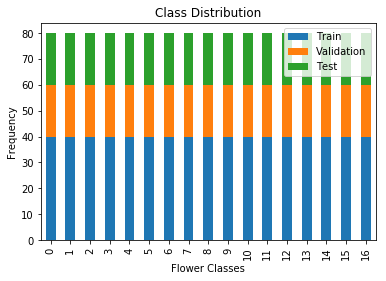

In [4]:
file_indexes = np.arange(len(_)) #Later will be used for debugging
X_train, X_test, y_train, y_test, train_ind, test_ind = train_test_split(image_feats, labels, file_indexes, test_size=0.25, random_state=2018, stratify = labels)
X_train, X_valid, y_train, y_valid, train_ind, valid_ind = train_test_split(X_train, y_train, train_ind, test_size=1/3, random_state=2018, stratify = y_train)

# Verify that the distributions have 50%, 25%, 25% split with stratified split
print("Train dataset size =", y_train.shape[0])
print("Validation dataset size =", y_valid.shape[0])
print("Test size =", y_test.shape[0])

# plot class distribution curve to make sure that data is correctly split
y_train_freq = np.bincount(y_train)
y_valid_freq = np.bincount(y_valid)
y_test_freq = np.bincount(y_test)
plotCurves(y_train_freq, y_valid_freq, y_test_freq)


The split reasoning is basically the difference between random sampling and stratified sampling. Random sampling allows random selection of sample, so that every sample in the population has equal probability of being selected. In stratified sampling, the samples are grouped according to their labels first (strata) and then a random sample is picked proportional to the number of members in every strata. This ensures class balance in all our training, validation and test sets. 

Class balance is very important for the performance of our SVM. Assume that the training data has 90% of class 0 and 10 % of class 1. The classifier can still obtain 90% training accuracy by classifying everything as class 0. 

Hence, we want our SVM to be 'see' data from every class proportional to the class frequency, so that a reasonable decision boundary can be learned.

### Save training, validation and test splits

In [5]:
np.save("X_train", X_train)
np.save("X_valid", X_valid)
np.save("X_test", X_test)

# Saving y may be unneccessary, but just to be safe:)
np.save("y_train", y_train)
np.save("y_valid", y_valid)
np.save("y_test", y_test)

### Create multiclass SVM model using linear kernel

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:38<00:00,  5.70s/it]


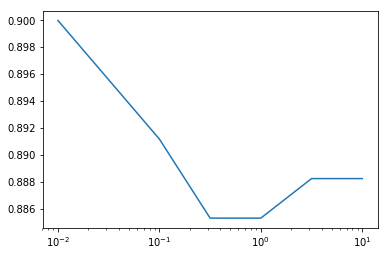

In [6]:
# Regularization constants

reg_values= [0.01, 0.1, 0.1**0.5, 1, 10**0.5, 10, 100**0.5]

# Initialize arrays to store training and validation errors
train_error_final = []
valid_error_final = []

# repeated training to get average accuracy
train_steps = 5
for c in tqdm(reg_values):
    train_error = []
    valid_error = []
    
    for i in range(train_steps):
        # Instantiate classifier
        clf = OneVsRestClassifier(estimator=LinearSVC(C=c))

        # Train the SVM
        clf.fit(X_train, y_train)

        # Evaluate performance on train and validation sets
        score_train = clf.score(X_train, y_train)
        score_valid = clf.score(X_valid, y_valid)

        # Append the scores
        train_error.append(score_train)
        valid_error.append(score_valid)
    
    train_error_final.append(s.mean(train_error))
    valid_error_final.append(s.mean(valid_error))

# Plot training and validation errors
#plt.plot(reg_values, train_error)
plt.plot(reg_values, valid_error_final)
plt.xscale('log')
plt.show()


In a SVM we are searching for two things: a hyperplane with the largest minimum margin, and a hyperplane that correctly separates as many instances as possible. A large regularization value will potentially give us a smaller margin and vice versa.

For every regualarization constant, I'm repeatedly training the SVM 5 times and taking the average accuracy. Analysing the validation accuracy graph, a regularization constant of 0.01 gives the highest accuracy. C = 0.01 seems to give a decent trade-off between misclassification instances and minimum margin size.

Hence, we will use C=0.01 for our final training

### Re-train on Training + Validation set

In [7]:
X_final_train = np.concatenate((X_train, X_valid), axis=0)
y_final_train = np.concatenate((y_train, y_valid), axis=0)

clf = OneVsRestClassifier(estimator=LinearSVC(C=10e-2))
clf.fit(X_final_train, y_final_train)

OneVsRestClassifier(estimator=LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=1)

### Evaluate Performance on Test Set

In [8]:
y_pred = clf.predict(X_test)
test_score = clf.score(X_test, y_test)
print('Test time Accuracy: {}'.format(test_score))

Test time Accuracy: 0.9147058823529411


### Understand where the classifer went wrong

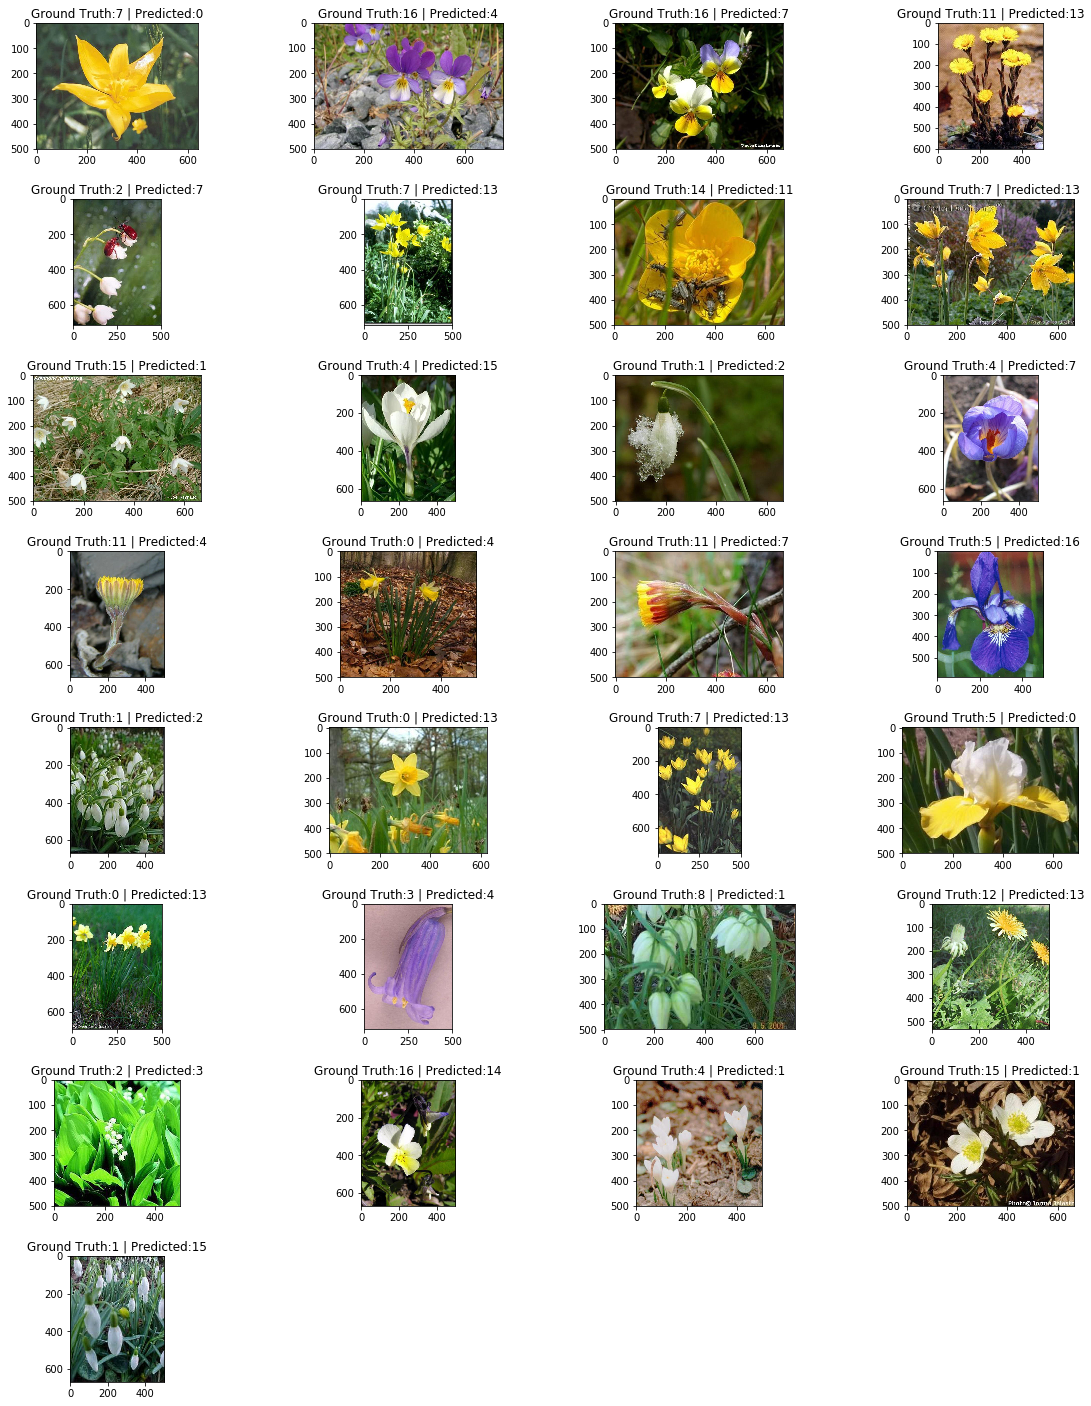

In [9]:
confused_images = [] # Will have the filename, ground_truth and prediction
for i in range(y_test.shape[0]):
    if y_test[i] != y_pred[i]:
        result = [_[test_ind[i]], y_test[i], y_pred[i]]
        confused_images.append(result)
        
plotImages(confused_images)

It is quite difficult to reason for these misclassified instances since I'm not aware of what features were extracted from the image. Therefore, any claims/ reasons I make will not have sufficient evidance. But I do have some insights.
1. Many of the misclassified floweres are predicted as class 13
2. Most of the misclassfied flowers are in yellow color.
3. Space occupied by the misclassified flowers are actually small in many instances compared to the size of the image.
4. Having more than 1 flower may lead to misclassification.